# Response Dynamics in an Olivocerebellar Spiking Neural Network With Non-linear Neuron Properties


Through this notebook you can run simulations of an olivocerebellar scaffold model with E-GLIF point neurons, as described in _Geminiani A<sup>*</sup>, Pedrocchi A, D’Angelo E and Casellato C (2019) Response Dynamics in an Olivocerebellar Spiking Neural Network With Non-linear Neuron Properties. Front. Comput. Neurosci. 13:68. doi: 10.3389/fncom.2019.00068_

<sup>*</sup> Corresponding author email: alice.geminiani@unipv.it

</br>

<div align=justify>The olivo-cerebellar scaffold includes the main neuron types and connections in the cerebellum and Inferior Olive and is organized into 2 microcomplexes (cortical microzones and corresponding nuclear and olivary volumes) as represented in the figure. Neurons are modelled as E-GLIF point neurons [_Geminiani et al., Front Neuroinform, 2018_], able to reproduce the main firing properties of cerebellar cells (e.g. autorhythm, adaptation, rebound bursting, oscillations) with limited computational load. 
The network is stimulated with sensory-like input signals to the Granular layer and the Inferior Olive. For the first time in a computational model, we show here how single neuron and network properties in the cerebellum contribute to the neural activity of Deep Cerebellar Nuclei, the sole output of the cerebellum. </div>


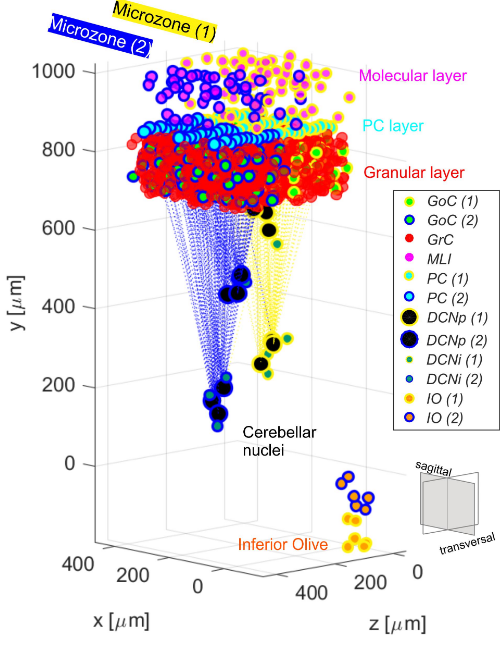

## Using this notebook
 
- You have to execute this notebook by running each cell consecutively.
- The notebook includes 3 main sections:

    1. __Preparation of the environment__, where the environment for simulations is set, installing all the necessary software (e.g. the neural simulator NEST)
    2. __Simulation__, where the simulation is prepared (defining the neural populations and the connections in the network, and the input stimuli) and run
    3. __Simulation data analysis__, where raster plot and PSTH of recorded neural populations can be visualized.
    
- To retain any changes made, you need to save the notebook. 

For detailed information about the notebook interface see _Help -> User Interface Tour_ in the menu, and the [Guidebook](https://lbologna.github.io/hbp-sp6-guidebook/getting_started/getting_started.html#working-with-collabs) for working with Collabs.

## 1. Preparation of the environment

Installation of everything that is needed to run the simulation

In [ ]:
!pip install -q --upgrade "hbp-service-client==1.0.0"

In [ ]:
cd

First, use module *os* to clean workspace from .gdf or .dat files (file storing spikes and voltage traces from previous simulations, respectively

In [ ]:
import os

def remove_files():
    for f in os.listdir('.'):
        if '.gdf' in f or '.dat' in f:
            os.remove(f)
            
remove_files()

### Install NEST 2.18.0 and _cereb-nest_ module

Get NEST 2.18.0 from Zenodo and install it

In [ ]:
!rm -rf nest-simulator-2.18.0/
!wget -P /home/jovyan "https://zenodo.org/record/2605422/files/nest-simulator-2.18.0.tar.gz"
!tar -xzf nest-simulator-2.18.0.tar.gz
!rm -rf nest-simulator-2.18.0-build/
!mkdir nest-simulator-2.18.0-build/
!rm nest-simulator-2.18.0.tar.gz*

In [ ]:
cd /home/jovyan/nest-simulator-2.18.0-build

In [ ]:
!cmake -Dwith-mpi=OFF -Dwith-openmp=OFF -DCMAKE_INSTALL_PREFIX:PATH=/home/jovyan/nest-simulator-2.18.0-build /home/jovyan/nest-simulator-2.18.0/
!make -j16
!make install

Check if NEST is properly installed

In [ ]:
import sys
sys.path[0] = '/home/jovyan/nest-simulator-2.18.0-build/lib/python3.6/site-packages/'

import nest
print(nest.version())

Install _cereb-nest_ module (https://github.com/dbbs-lab/cereb-nest), which contains custom NEST models for simulations of cerebellar neurons and synapses, including the E-GLIF neuron model.

In [ ]:
cd

In [ ]:
!rm -rf cereb-nest cereb-nest-build
!git clone https://github.com/dbbs-lab/cereb-nest.git
!mkdir cereb-nest-build

In [ ]:
cd cereb-nest-build

In [ ]:
!cmake -Dwith-nest=/home/jovyan/nest-simulator-2.18.0-build/bin/nest-config /home/jovyan/cereb-nest
!make
!make install

Set environment variables and install the module

In [ ]:
os.environ["NEST_MODULE_PATH"] = "/home/jovyan/nest-simulator-2.18.0-build/lib/nest"
os.environ["SLI_PATH"] = "/home/jovyan/nest-simulator-2.18.0-build/share/nest/sli"
os.environ["LD_LIBRARY_PATH"] = "/home/jovyan/nest-simulator-2.18.0-build/lib/nest"

nest.Install("cerebmodule")

## 2. Simulation

Simulations of the olivocerebellar scaffold with E-GLIF neurons. 


In [ ]:
# Import
from __future__ import print_function  # python 2 & 3 compatible

import time
import numpy as np
import h5py
import nest
import random
from operator import itemgetter
from multiprocessing import cpu_count

import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


# Load file with positions and connections data
client = get_hbp_service_client()
cerebellum_storage = '/80131'
path = cerebellum_storage + '/Network/'
hdf5_file = 'scaffold_full_IO_400.0x400.0_microzone.hdf5'
client.storage.download_file(path+hdf5_file, hdf5_file)

Define parameters of single neuron types and connections

In [ ]:
# Synapse parameters: in E-GLIF, 3 synaptic receptors are present: the first is always associated to exc, the second to inh, the third to remaining synapse type
Erev_exc = 0.0		# [mV]	#[Cavallari et al, 2014]
Erev_inh = -80.0		# [mV]
tau_exc = {'golgi': 0.23, 'granule': 5.8, 'purkinje': 1.1, 'basket': 0.64, 'stellate': 0.64, 'dcn': 1.0, 'dcnp': 3.64, 'io': 1.0}		#tau_exc for pc is for pf input; tau_exc for goc is for mf input; tau_exc for mli is for pf input
tau_inh = {'golgi': 10.0, 'granule': 13.61, 'purkinje': 2.8, 'basket': 2.0, 'stellate': 2.0, 'dcn': 0.7, 'dcnp': 1.14, 'io': 60.0}
tau_exc_cfpc = 0.4
tau_exc_pfgoc = 0.5
tau_exc_cfmli = 1.2

# Single neuron parameters:
neuron_param = {'golgi': {'t_ref': 2.0, 'C_m': 145.0,'tau_m': 44.0,'V_th': -55.0,'V_reset': -75.0,'Vinit': -62.0,'E_L': -62.0,'Vmin':-150.0,
                         'lambda_0':1.0, 'tau_V':0.4,'I_e': 16.214,'kadap': 0.217,'k1': 0.031, 'k2': 0.023,'A1': 259.988,'A2':178.01,
                         'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['golgi'], 'tau_syn2': tau_inh['golgi'], 'tau_syn3': tau_exc_pfgoc},
               'granule': {'t_ref': 1.5, 'C_m': 7.0,'tau_m': 24.15,'V_th': -41.0,'V_reset': -70.0,'Vinit': -62.0,'E_L': -62.0,'Vmin': -150.0,
                           'lambda_0':1.0, 'tau_V':0.3,'I_e': -0.888,'kadap': 0.022,'k1': 0.311, 'k2': 0.041,'A1': 0.01,'A2':-0.94,
                           'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['granule'], 'tau_syn2': tau_inh['granule'], 'tau_syn3': tau_exc['granule']},
               'purkinje': {'t_ref': 0.5, 'C_m': 334.0,'tau_m': 47.0,'V_th': -43.0,'V_reset': -69.0,'Vinit': -59.0,'E_L': -59.0,
                            'lambda_0':4.0, 'tau_V':3.5,'I_e': 742.54,'kadap': 1.492,'k1': 0.1950, 'k2': 0.041,'A1': 157.622,'A2':172.622,
                            'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['purkinje'], 'tau_syn2': tau_inh['purkinje'], 'tau_syn3': tau_exc_cfpc},
               'basket': {'t_ref': 1.59, 'C_m': 14.6,'tau_m': 9.125,'V_th': -53.0,'V_reset': -78.0,'Vinit': -68.0,'E_L': -68.0,
                          'lambda_0':1.8, 'tau_V':1.1,'I_e': 3.711,'kadap': 2.025,'k1': 1.887, 'k2': 1.096,'A1': 5.953,'A2':5.863,
                          'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['basket'], 'tau_syn2': tau_inh['basket'], 'tau_syn3': tau_exc_cfmli},
               'stellate': {'t_ref': 1.59, 'C_m': 14.6,'tau_m': 9.125,'V_th': -53.0,'V_reset': -78.0,'Vinit': -68.0,'E_L': -68.0,
                            'lambda_0':1.8, 'tau_V':1.1,'I_e': 3.711,'kadap': 2.025,'k1': 1.887, 'k2': 1.096,'A1': 5.953,'A2':5.863,
                            'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['basket'], 'tau_syn2': tau_inh['basket'], 'tau_syn3': tau_exc_cfmli},
               'dcn': {'t_ref': 0.8, 'C_m': 142.0,'tau_m': 33.0,'V_th': -36.0,'V_reset': -55.0,'Vinit': -45.0,'E_L': -45.0,
                       'lambda_0':3.5, 'tau_V':3.0,'I_e': 75.385,'kadap': 0.408,'k1': 0.697, 'k2': 0.047,'A1': 13.857,'A2':3.477,
                       'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['dcn'], 'tau_syn2': tau_inh['dcn'], 'tau_syn3': tau_exc['dcn']},
               'dcnp': {'t_ref': 0.8, 'C_m': 56.0,'tau_m': 56.0,'V_th': -39.0,'V_reset': -55.0,'Vinit': -40.0,'E_L': -40.0,
                        'lambda_0':0.9, 'tau_V':1.0,'I_e': 2.384,'kadap': 0.079,'k1': 0.041, 'k2': 0.044,'A1': 176.358,'A2':176.358,
                        'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['dcnp'], 'tau_syn2': tau_inh['dcnp'], 'tau_syn3': tau_exc['dcnp']},
               'io': {'t_ref': 1.0, 'C_m': 189.0,'tau_m': 11.0,'V_th': -35.0,'V_reset': -45.0,'Vinit': -45.0,'E_L': -45.0,
                      'lambda_0':1.2, 'tau_V':0.8,'I_e': -18.101,'kadap': 1.928,'k1': 0.191, 'k2': 0.091,'A1': 1810.93,'A2':1358.197,
                      'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['io'], 'tau_syn2': tau_inh['io'], 'tau_syn3': tau_exc['io']}}


# Connection weights
conn_weights = {'aa_goc': 1.2, 'aa_pc': 0.7, 'bc_pc': 0.3, 'dcnp_io': 3.0, 'gj_bc': 0.2, 'gj_sc': 0.2, 'glom_dcn': 0.05,\
                'glom_goc': 1.5, 'glom_grc': 0.15, 'goc_glom': 0.0, 'gj_goc': 0.3,'goc_grc': 0.6, 'io_dcn': 0.1, 'io_dcnp': 0.2,\
                'io_bc': 1.0,'io_sc': 1.0, 'io_pc': 350.0, 'pc_dcn': 0.4, 'pc_dcnp': 0.12, 'pf_bc': 0.015, 'pf_goc': 0.05,'pf_pc': 0.007,\
                'pf_sc': 0.015, 'sc_pc': 0.3}


# Connection delays
conn_delays = {'aa_goc': 2.0, 'aa_pc': 2.0, 'bc_pc': 4.0, 'dcnp_io': 20.0, 'gj_bc': 1.0, 'gj_sc': 1.0, 'glom_dcn': 4.0,
               'glom_goc': 4.0, 'glom_grc': 4.0, 'goc_glom': 0.5, 'gj_goc': 1.0, 'goc_grc': 2.0, 'io_dcn': 4.0, 'io_dcnp': 5.0,
               'io_bc': 70.0,'io_sc': 70.0, 'io_pc': 4.0, 'pc_dcn': 4.0, 'pc_dcnp': 4.0, 'pf_bc': 5.0, 'pf_goc': 5.0,'pf_pc': 5.0,
               'pf_sc': 5.0, 'sc_pc':5.0}

sd_iomli = 10.0          # IO-MLI delayes are set as normal distribution to reproduce the effect of spillover-based transmission
min_iomli = 40.0

# Connection receptors
conn_receptors = {'aa_goc': 3, 'aa_pc': 1, 'bc_pc': 2, 'dcnp_io': 2, 'gj_bc': 2, 'gj_sc': 2, 'glom_dcn': 1,
               'glom_goc': 1, 'glom_grc': 1, 'goc_glom': 1, 'gj_goc': 2, 'goc_grc': 2, 'io_dcn': 1, 'io_dcnp': 1,
               'io_bc': 3,'io_sc': 3, 'io_pc': 3, 'pc_dcn': 2, 'pc_dcnp': 2, 'pf_bc': 1, 'pf_goc': 3,'pf_pc': 1,
               'pf_sc': 1, 'sc_pc': 2}


Setup NEST and import network from .hdf5 file

In [ ]:
nest.ResetKernel()
nest.set_verbosity('M_ERROR')
nest.SetKernelStatus({"local_num_threads" : cpu_count()})


f = h5py.File(hdf5_file, 'r+')

### Creating population of neurons
Instantiate conductance based Extended-Generalized Leaky Integrate and Fire models (E-GLIF) for each cell type. 
The only exception is represented by Glomeruli; these are not actual cells but just 'relays', used to deliver input spikes to other cells. Here, Glomeruli are created as *parrot_neurons*

In [ ]:
### Load neuron positions from hdf5 file and create them in NEST:
positions = np.array(f['positions'])


# Create a dictionary where keys = nrntype IDs, values = cell names (strings)
# Cell type ID (can be changed without constraints)
cell_type_ID = {'golgi': 1,
                'glomerulus': 2,
                'granule': 3,
                'purkinje': 4,
                'basket': 5,
                'stellate': 6,
                'dcn': 7,
                'dcnp': 8,
                'io': 9}

id_2_cell_type = {val: key for key, val in cell_type_ID.items()}
# Sort nrntype IDs 
sorted_nrn_types = sorted(list(cell_type_ID.values()))
# Create a dictionary; keys = cell names, values = lists to store neuron models
neuron_models = {key: [] for key in cell_type_ID.keys()}

# All cells are modelled as E-GLIF models;
# with the only exception of Glomeruli (not cells, just modeled as
# relays; i.e., parrot neurons)
for cell_id in sorted_nrn_types:
    cell_name = id_2_cell_type[cell_id] 
    if cell_name  != 'glomerulus':
        if cell_name not in nest.Models():
            nest.CopyModel('eglif_cond_alpha_multisyn', cell_name)
            nest.SetDefaults(cell_name, neuron_param[cell_name])
    else:
        if cell_name not in nest.Models():
            nest.CopyModel('parrot_neuron', cell_name)
            
    cell_pos = positions[positions[:,1]==cell_id, :]
    neuron_models[cell_name] = nest.Create(cell_name, cell_pos.shape[0])

### Creating synaptic connections

Here we create synaptic connections among neurons. A message will be printed below the next cell when each connection type is done

In [ ]:
### Load connections from hdf5 file and create them in NEST:
for conn in conn_weights.keys():
    exec(conn+" = np.array(f['connections/'+conn])")
    exec("pre = [int(x+1) for x in "+conn+"[:,0]]")
    exec("post = [int(x+1) for x in "+conn+"[:,1]]")
    if conn == "io_bc" or conn == "io_sc":
        syn_param = {"model": "static_synapse", "weight": conn_weights[conn], \
                     "delay": {'distribution': 'normal_clipped', 'low': min_iomli, 'mu': conn_delays[conn],
                       'sigma': sd_iomli},"receptor_type":conn_receptors[conn]}
    else:
        syn_param = {"model": "static_synapse", "weight": conn_weights[conn], "delay": conn_delays[conn],"receptor_type":conn_receptors[conn]}

    nest.Connect(pre,post, {"rule": "one_to_one"}, syn_param)
    print("Connections ", conn, " done!")
    

f.close()


### Defining stimuli

Into the next cell, the user can define the parameters value for the simulation. Stimuli are associated to sensorimotor signals of eyeblink classical conditioning: a tone-like input to all glomeruli (Conditioned Stimulus - CS), an air puff-like bursting stimulus to Inferior Olive neurons connected to microzone 1 only (Unconditioned Stimulus - US). The background input is a 4 Hz Poisson process to glomeruli. The user can set the following parameters:
1. RECORD_VM: by default, spike data are recorded. If you want to record voltage-traces too, please set this variable to 'True', but consider that this is going to increase the computational time of the simulation.
2. TOT_DURATION: duration of whole simulation, in milliseconds. 
3. CS_START: when the CS (a Poisson process spike train) should start.
4. CS_END : when the CS should stop.
5. CS_FREQ: frequency of the CS.
6. US_START: when the US (a burst) should start.
7. US_END : when the US should stop - coterminating with CS.
8. US_FREQ : frequence of the US.
9. RADIUS: the radius of the cylindrical Granular layer volume that will be stimulated (to avoid border effects).

In [ ]:
RECORD_VM = False
TOT_DURATION = 1260. # mseconds
CS_START = 500. # beginning of stimulation
CS_END = 760.   # end of stimulation
CS_FREQ = 36.  # Frequency in Hz (considering the background at 4 Hz (sum of Poisson processes = Poisson proc with the sum of rates)
US_START = 750.  # beginning of stimulation
US_END = 760.  # end of stimulation
US_FREQ = 500.  # Frequency in Hz
RADIUS = 150. # [um] - radius of glomeruli stimulation cylinder to avoid border effects

Create stimulation devices in NEST and connect to input neural populations (Glomeruli or Inferior Olive neurons).

In [ ]:
glom_num = len(neuron_models['glomerulus'])
io_num = len(neuron_models['io'])

CS = nest.Create('poisson_generator',params={'rate':CS_FREQ, 'start': CS_START, 'stop': CS_END})

 
# CS as Poisson process
gloms_pos = positions[positions[:,1]==cell_type_ID['glomerulus'], :]
x_c, z_c = 200., 200.
 
# Connection to glomeruli falling into the selected volume, i.e. a cylinder in the Granular layer
target_gloms_idx = np.sum((gloms_pos[:,[2,4]] - np.array([x_c, z_c]))**2, axis=1).__lt__(RADIUS**2)
target_gloms = gloms_pos[target_gloms_idx,0]+1
id_stim = [glom for glom in neuron_models['glomerulus'] if glom in target_gloms]
id_stim = sorted(list(set(id_stim)))
n = len(id_stim)

nest.Connect(CS, id_stim)
 

# US as burst    
spike_nums = np.int(np.round((US_FREQ * (US_END - US_START)) / 1000.))
US_array = (np.round(np.linspace(US_START, US_END, spike_nums)))       

US = ()
for ii in range(int(io_num/2)):
    US_new = nest.Create('spike_generator')
    nest.SetStatus(US_new, {'spike_times': US_array})
    US = US + US_new
        
# Connection to first half of IO, corresponding to first microzone
syn_param = {"model": "static_synapse", "weight":55.0, "delay": 0.1,"receptor_type":1}
nest.Connect(US,neuron_models['io'][:int(io_num/2)],{'rule':'one_to_one'},syn_param)        
 
    
# Background as Poisson process 
background = nest.Create('poisson_generator',params={'rate':4.0, 'start': 0.0, 'stop': TOT_DURATION}) 
nest.Connect(background,neuron_models['glomerulus'])           


### Defining recording devices
Create spike detectors and connect them to the cells; if the user selected RECORD_VM, also voltage will be recorded

In [ ]:
## Record spikes from granule and Golgi cells
grc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": True, "label": "granule_spikes"})
goc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": True, "label": "golgi_spikes"})
glom_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": True, "label": "glomerulus_spikes"})
pc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": True, "label": "purkinje_spikes"})
bc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": True, "label": "basket_spikes"})
sc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": True, "label": "stellate_spikes"})
dcn_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": True, "label": "dcn_spikes"})

# Here you can choose which devices you want to connect and thus the neural populations you want to record.
# Increasing the number of recorded cells can increase the duration of the simulation
nest.Connect(neuron_models['purkinje'], pc_spikes)
nest.Connect(neuron_models['basket'], bc_spikes)
nest.Connect(neuron_models['stellate'], sc_spikes)
nest.Connect(neuron_models['dcn'], dcn_spikes)

        
if RECORD_VM:
    print("Recording membrane voltage")
    grc_vm = nest.Create("multimeter")
    goc_vm = nest.Create("multimeter")
    pc_vm = nest.Create("multimeter")
    bc_vm = nest.Create("multimeter")
    sc_vm = nest.Create("multimeter")                     
    dcn_vm = nest.Create("multimeter")

    nest.SetStatus(grc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": True, "label": "granule_vm"})
    nest.SetStatus(goc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": True, "label": "golgi_vm"})
    nest.SetStatus(pc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": True, "label": "purkinje_vm"})
    nest.SetStatus(bc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": True, "label": "basket_vm"})
    nest.SetStatus(sc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": True, "label": "stellate_vm"})
    nest.SetStatus(dcn_vm, {"withtime": True, "record_from": ["V_m"], "to_file": True, "label": "dcn_vm"})


    nest.Connect(grc_vm, neuron_models['granule'])
    nest.Connect(goc_vm, neuron_models['golgi'])
    nest.Connect(pc_vm, neuron_models['purkinje'])
    nest.Connect(bc_vm, neuron_models['basket'])
    nest.Connect(sc_vm, neuron_models['stellate'])
    nest.Connect(dcn_vm, neuron_models['dcn'])

### Running simulation

This part can take a while (~40 min)

In [ ]:
nest.Simulate(TOT_DURATION)

# Get spike events for each recording device - the neural populations that you decided not to record will have empty spike detectors
GoCspikes = nest.GetStatus(goc_spikes, keys='events')[0]
goc_evs = GoCspikes['senders']
goc_ts = GoCspikes['times']

GrCspikes = nest.GetStatus(grc_spikes, keys='events')[0]
grc_evs = GrCspikes['senders']
grc_ts = GrCspikes['times']

Glomspikes = nest.GetStatus(glom_spikes, keys='events')[0]
glom_evs = Glomspikes['senders']
glom_ts = Glomspikes['times']

Purkinjespikes = nest.GetStatus(pc_spikes, keys='events')[0]
pc_evs = Purkinjespikes['senders']
pc_ts = Purkinjespikes['times']

Basketspikes = nest.GetStatus(bc_spikes, keys='events')[0]
bc_evs = Basketspikes['senders']
bc_ts = Basketspikes['times']

Stellatespikes = nest.GetStatus(sc_spikes, keys='events')[0]
sc_evs = Stellatespikes['senders']
sc_ts = Stellatespikes['times']

Dcnspikes = nest.GetStatus(dcn_spikes, keys='events')[0]
dcn_evs = Dcnspikes['senders']
dcn_ts = Dcnspikes['times']

## 3. Simulation data analysis

### Raster Plot 

Below, a raster plot of cell spikes for each cell type can be displayed; select the cell type modifying the CELL_TO_PLOT variable.
Cell types are:
1. 'granule'
2. 'golgi'
3. 'purkinje'
4. 'stellate'
5. 'basket'
6. 'dcn'

For Purkinje and DCN neurons, you can specify the microzone you want to analyze: microzone 1 is receiving both CS and US, while microzone 2 receives only CS (empty lines in raster plots would represent neurons of the other microzone). In the first case, US triggers burst-pause and pause-burst mechanisms, which are fundamental to fine tune the timing of cerebellar motor outputs.

Attention: you can plot only the activity of cell types whose recording device were connected before the simulation run!

In [ ]:
CELL_TO_PLOT = 'purkinje'

microzone = '2'

cells = {'granule': [grc_ts, grc_evs],
         'golgi': [goc_ts, goc_evs],
         'purkinje': [pc_ts, pc_evs],
         'stellate': [sc_ts, sc_evs],
         'basket': [bc_ts, bc_evs],
         'dcn': [dcn_ts, dcn_evs]}

index_zones = {'purkinje': {'1': list(range(95457,95490)) + [95491, 95492], '2': list(range(95493,95526)) + [95490]},
              'dcn': {'1': list(range(96735,96738)) + list(range(96741,96744)), '2': list(range(96732,96735)) + list(range(96738,96741))}}

color = {'granule': 'rgba(255, 0, 0, .8)',
         'golgi': 'rgba(0, 255, 0, .8)',
         'purkinje': 'rgba(64, 224, 208, .8)',
         'stellate': 'rgba(234, 10, 142, .8)',
         'basket': 'rgba(234, 10, 142, .8)',
         'dcn': 'rgba(0, 0, 0, .8)'
        }

times = cells[CELL_TO_PLOT][0]
cell_ids = cells[CELL_TO_PLOT][1]

idx = []

if CELL_TO_PLOT in index_zones:
    for i in range(len(cell_ids)):
        if cell_ids[i] in index_zones[CELL_TO_PLOT][microzone]:
            idx = idx + [i]
     #np.nonzero(np.isin(cell_ids,index_zones[CELL_TO_PLOT][microzone]))
    times = times[idx]
    cell_ids = cell_ids[idx]
    
    
    
    
trace0 = go.Scatter(
    x = times,
    y = cell_ids,
    name = '',
    mode = 'markers',
    marker = dict(
        size = 4,
        color = color[CELL_TO_PLOT],
        line = dict(
            width = .2,
            color = 'rgb(0, 0, 0)'
        )
    )
)

data = [trace0]

layout = go.Layout(
              title = 'Spikes raster plot',
              yaxis = dict(title='Neuron GID', zeroline = False),
              xaxis = dict(title='Time [msecs]', zeroline = False, range=[0,TOT_DURATION+1]),
              shapes= [
              # Line CS start
              {
                  'type': 'line',
                  'x0': CS_START,
                  'y0': np.amin(cell_ids),
                  'x1': CS_START,
                  'y1': np.amax(cell_ids),
                  'line': {
                      'color': 'rgb(55, 128, 191)',
                      'width': 2,
                  }
               },
               # Line US start
               {
                  'type': 'line',
                  'x0': US_START,
                  'y0': np.amin(cell_ids),
                  'x1': US_START,
                  'y1': np.amax(cell_ids),
                  'line': {
                      'color': 'rgb(55, 128, 191)',
                      'width': 2,
                  }
               },
               # Line CS and US stop
               {
                  'type': 'line',
                  'x0': CS_END,
                  'y0': np.amin(cell_ids),
                  'x1': CS_END,
                  'y1': np.amax(cell_ids),
                  'line': {
                      'color': 'rgb(55, 128, 191)',
                      'width': 2,
                  }
               }]
             )

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='styled-scatter')

### PSTH plot of spikes 

Define the function to extract spike histograms

In [ ]:
def metrics(spikeData, TrialDuration, cell):
    id_spikes = np.sort(np.unique(spikeData,return_index=True))
    #k = np.mean(spikeData)
    #v = np.var(spikeData)
    #delta = 0.1*(np.sqrt(np.abs((k**2)-v)))
    bin_size = 5   # [ms]
    n_bins = int(TrialDuration/bin_size) + 1
    psth, tms = np.histogram(spikeData, bins = n_bins, range = (0 , TrialDuration))
    
    # absolute frequency
    abs_freq = np.zeros(id_spikes[0].shape[0])
    for idx,i in enumerate(id_spikes[0]):
        count = np.where(spikeData==i)[0]
        abs_freq[idx] = count.shape[0]
    
    # mean frequency
    m_f = (id_spikes[0].shape[0])/TrialDuration
    
    # graph using plotly
    data = [
        go.Bar(
        x = tms[0:len(tms)-1],
        y = psth,
        width = 4.0,
        marker=dict(
            color=color[CELL_TO_PLOT])
        )]
    
    layout = go.Layout(
            scene = dict(aspectmode='data'),
            xaxis={'title':'time (ms)'}, 
            yaxis={'title':'number of spikes'},
            shapes= [
            # Line CS start
            {
                'type': 'line',
                'x0': CS_START,
                'y0': 0,
                'x1': CS_START,
                'y1': np.amax(psth)+10,
                'line': {
                    'color': 'rgb(55, 128, 191)',
                    'width': 2,
                }
            },
            # Line US start
            {
                'type': 'line',
                'x0': US_START,
                'y0': 0,
                'x1': US_START,
                'y1': np.amax(psth)+10,
                'line': {
                    'color': 'rgb(55, 128, 191)',
                    'width': 2,
                }
            },
            # Line CS and US stop
            {
                'type': 'line',
                'x0': CS_END,
                'y0': 0,
                'x1': CS_END,
                'y1': np.amax(psth)+10,
                'line': {
                    'color': 'rgb(55, 128, 191)',
                    'width': 2,
                }
            }]
    )
    
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='psth')

    print("absolute frequency: ", abs_freq)
    print("mean frequency: ", m_f)
    
    return tms

<div align=justify>Plot the histogram of spikes. 
For all cell type you can observe an increased firing rate during the Conditioned Stimulus, whose amount depends on the balance between excitatory and inhibitory input received by that neural population. For neurons receiving also the Unconditioned Stimulus through Inferior Olive connections, you can observe pause and/or bursting responses, resulting from E-GLIF dynamics and network topology. For Molecular Layer Interneurons, the spillover-mediated connections from Inferior Olive cause a delayed increase of firing rate following the US.</div>

In [ ]:
metrics(times, TOT_DURATION, CELL_TO_PLOT)

### Save data to Collab storage

Executing the following cell is optional; if you want to download spike (.gdf) and / or voltage (.dat) files for further analysis, the next code snippet will save data into the storage (this might take a few minutes)

In [ ]:
from datetime import datetime

local_storage = get_collab_storage_path()
dirname = local_storage+'/nest_sim_'+datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
client.storage.mkdir(dirname)
for nest_file in os.listdir('.'):
    if '.gdf' in nest_file or '.dat' in nest_file:
        client.storage.upload_file(nest_file, dirname+'/'+nest_file, 'text/plain')
        print('{} uploaded'.format(nest_file))